# Gradient boosting for Work Engagement Latent variable regression

In [5]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing libraries for machine learning
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import dump,load
import shap


# Importing libraries for hyperparameter optimization
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
# Display setting for exploration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [6]:
# Check out if the environment is the correct Anaconda one
import sys
print('environment: ',sys.executable)

# Set up directory to be the github repository
# requires git
import os
import subprocess
os.getcwd()
output = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'])
path = output.decode('utf-8').strip()
print('working directory: ',path)
os.chdir(path)


environment:  c:\Users\ricca\anaconda3\envs\Thesis\python.exe
working directory:  C:/Users/ricca/Documents/GitHub/Thesis-SEM-ML


In [7]:
from Source.DataPreparation.DataProcessor import DataProcessor
from Source.Regression.latent_variable_regressors import GBoostRegression, RFRegression, LinearRegressionModel
default_rs=42

In [13]:
processorclass=DataProcessor()
processorclass.read_df()
processorclass.split_data(random_state=default_rs)
processorclass.save_data()
processorclass.process_CFA()

In [14]:
X_train,y_train,X_test,y_test = processorclass.train_test_data_for_WEtarget(target_variable='WorkEngagement',Categories=False)
display(X_test)

,telework,wp_size,private_sector,seniority,part_time,empl_contract,repetitive_movements,asb_verbal,asb_unwanted_sexatt,asb_violence_harassment,discrimination,emot_disturb,night,usual_hours_week,shortnotice,able_hour_off,undesirable_change,losejob,training_employer,training_onthejob,learning_new_things,work_welldone,usefull_work,predict_earnings,ProfessionalSupport,JobOverload,Environmentalrisks,WorkAgency,WHO5
0,6,4,1,26,2,6,<NA>,<NA>,<NA>,<NA>,2,4,2,43,5,4,4,1,2,2,5,4,5,3,-0.280002,0.334880,-0.220972,-0.420407,-0.039092
1,4,6,2,2,2,6,5,2,2,2,2,5,3,35,<NA>,3,1,2,2,2,5,4,5,3,0.040421,-0.245965,0.460461,0.314083,0.132308
2,1,3,1,<NA>,1,5,<NA>,<NA>,<NA>,<NA>,2,3,3,40,4,3,1,2,1,2,5,5,5,2,0.016596,0.163436,0.717667,-0.166545,-0.462013
3,6,6,2,38,2,6,4,2,2,2,2,2,3,40,<NA>,3,2,2,2,1,4,5,5,3,0.073073,0.052183,0.307163,0.067107,0.631984
4,2,4,1,<NA>,2,5,<NA>,<NA>,<NA>,<NA>,1,2,1,45,5,3,2,3,1,2,4,3,3,2,-0.454226,0.204644,-0.264459,-0.732509,-0.202200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,5,2,1,<NA>,2,6,<NA>,<NA>,<NA>,<NA>,2,1,3,48,5,3,1,4,1,1,5,5,5,1,0.487019,-0.109387,0.070106,0.223652,0.568205
354,5,5,1,<NA>,2,6,<NA>,<NA>,<NA>,<NA>,2,2,2,50,5,3,2,4,1,1,5,4,4,1,-0.117673,0.403519,-0.265642,0.228177,-0.108486
355,3,2,1,24,1,6,<NA>,<NA>,<NA>,<NA>,2,1,1,25,5,4,1,1,1,1,4,4,4,2,1.080121,-0.673122,-0.591245,0.202007,1.013791
356,6,1,1,30,2,6,1,2,2,2,2,1,1,60,5,3,<NA>,1,<NA>,<NA>,4,4,<NA>,3,0.116016,-0.312481,-0.110380,0.289763,0.605815


In [15]:
Xgboost=GBoostRegression(x_train=X_train,y_train=y_train,x_test=X_test,y_test=y_test)
Xgboost.train(verbosity=0,n_iter=60)
results=Xgboost.get_results(verbose=1)
Xgboost.save_model(model_name='xgbregressor_WE_latent')

Starting the XGBRegressor training
Best Parameters:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': 0.5, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.0, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.026362008116868174, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 10, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 321, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 5.0, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


Metrics:
MSE: 0.07842719355837484
MAE: 0.21671

In [29]:
X_train_shuffled = X_train.sample(frac=1).reset_index(drop=True)
X_test_shuffled = X_test.sample(frac=1).reset_index(drop=True)

In [30]:
Xgboost=GBoostRegression(x_train=X_train_shuffled,y_train=y_train,x_test=X_test_shuffled,y_test=y_test)
Xgboost.train(verbosity=0,scoringmetric='r2')
results=Xgboost.get_results(verbose=1)
#Xgboost.save_model(model_name='helloworld2')

Starting the XGBRegressor training
Best Parameters:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': 0.5, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.5, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.010818219707620844, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 223, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 5.0, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


Metrics:
MSE: 0.4314880834556884
MAE: 0.5136396

# Observed Regression

In [8]:
from sklearn import model_selection

In [9]:
df = pd.read_csv("data\\processed\\factordatasets\\CFAObservedf.csv")
df.drop(columns=['ID', 'SurveyCombination_M1','SurveyCombination_M2', 'Country', 'age','gender_recoded'], inplace=True)

train_df, test_df = model_selection.train_test_split(
                    df, 
                    test_size=0.3, 
                    random_state=42
                )

display(train_df)

,telework,wp_size,private_sector,seniority,part_time,empl_contract,noise,carrying_loads,repetitive_movements,asb_verbal,asb_unwanted_sexatt,asb_violence_harassment,chemicals,infect,tiring_positions,lifting,support_colleagues,support_manager,discrimination,highspeed,tightdead,emot_disturb,autonomy_order,autonomy_method,autonomy_speed,consulted,improv_workorg,decision_influence,freetime_work,night,usual_hours_week,shortnotice,able_hour_off,prospects,undesirable_change,losejob,training_employer,training_onthejob,learning_new_things,recognition,opportunities_job,work_welldone,usefull_work,er_balance,wp_mantrustemp,wp_goodcoop,wp_emptrustman,work_life_balance,wlb_worry,wlb_tired,wlb_concentration,predict_earnings,who5_cheerful,who5_relaxed,who5_active,who5_rested,who5_interesting,WorkEngagement
596,6,NaN,2.0,7.0,2.0,5.0,2.0,1,4.0,2.0,2.0,2.0,1.0,1,1.0,1,5.0,5.0,2.0,3.0,4.0,1.0,4.0,4,5.0,4.0,4.0,4.0,2.0,3,36.0,5.0,3.0,NaN,NaN,2.0,NaN,NaN,3,4.0,4.0,5.0,NaN,NaN,4.0,4.0,4.0,1.0,3.0,3.0,3.0,3.0,4.0,3,3.0,4.0,4,-0.011656
735,4,4.0,1.0,24.0,2.0,6.0,NaN,1,NaN,NaN,NaN,NaN,1.0,1,NaN,1,5.0,NaN,1.0,4.0,4.0,3.0,3.0,3,3.0,5.0,4.0,4.0,1.0,1,40.0,5.0,3.0,2.0,2.0,2.0,2.0,2.0,4,4.0,5.0,4.0,5.0,4.0,5.0,5.0,4.0,2.0,4.0,4.0,3.0,3.0,3.0,1,4.0,4.0,5,-0.083326
479,6,4.0,1.0,20.0,2.0,6.0,NaN,1,NaN,NaN,NaN,NaN,1.0,1,NaN,1,5.0,NaN,2.0,4.0,2.0,3.0,4.0,4,4.0,5.0,3.0,3.0,1.0,1,42.0,5.0,4.0,2.0,1.0,1.0,2.0,1.0,3,4.0,4.0,4.0,4.0,4.0,4.0,5.0,3.0,1.0,2.0,2.0,1.0,3.0,5.0,4,4.0,4.0,5,-0.011656
959,1,3.0,1.0,12.0,1.0,6.0,NaN,1,NaN,NaN,NaN,NaN,1.0,1,NaN,4,5.0,NaN,2.0,2.0,3.0,1.0,4.0,4,4.0,4.0,5.0,3.0,1.0,1,25.0,5.0,3.0,1.0,1.0,1.0,1.0,1.0,4,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,2.0,3.0,3.0,4.0,3.0,4.0,5,2.0,2.0,4,0.602174
936,2,6.0,1.0,6.0,2.0,6.0,NaN,1,NaN,NaN,NaN,NaN,1.0,1,NaN,1,5.0,NaN,2.0,2.0,1.0,1.0,3.0,3,5.0,5.0,4.0,3.0,1.0,1,40.0,5.0,4.0,4.0,1.0,1.0,1.0,2.0,4,4.0,4.0,5.0,5.0,4.0,5.0,5.0,5.0,1.0,2.0,3.0,3.0,3.0,4.0,2,2.0,6.0,4,0.026962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,3,8.0,1.0,20.0,2.0,6.0,1.0,1,3.0,2.0,2.0,2.0,1.0,1,3.0,1,4.0,4.0,2.0,4.0,3.0,3.0,4.0,4,4.0,5.0,4.0,4.0,2.0,2,40.0,5.0,3.0,NaN,NaN,2.0,NaN,NaN,4,2.0,3.0,4.0,NaN,NaN,3.0,4.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3,3.0,3.0,3,-0.389212
1095,1,3.0,2.0,NaN,2.0,5.0,3.0,1,1.0,2.0,2.0,2.0,1.0,1,1.0,1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3,3.0,4.0,4.0,5.0,2.0,1,25.0,5.0,2.0,NaN,NaN,NaN,NaN,NaN,5,3.0,4.0,5.0,NaN,NaN,5.0,4.0,5.0,2.0,3.0,3.0,2.0,1.0,3.0,1,5.0,2.0,2,0.409308
1130,2,8.0,1.0,33.0,2.0,6.0,NaN,1,NaN,NaN,NaN,NaN,4.0,3,NaN,1,4.0,NaN,2.0,2.0,2.0,1.0,5.0,5,4.0,4.0,4.0,4.0,1.0,1,40.0,5.0,4.0,3.0,2.0,1.0,1.0,1.0,4,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,2.0,3.0,3.0,2.0,3.0,4.0,4,4.0,4.0,3,-0.714629
860,6,5.0,1.0,4.0,2.0,6.0,1.0,1,4.0,2.0,2.0,2.0,1.0,1,1.0,1,4.0,4.0,2.0,3.0,3.0,2.0,4.0,4,4.0,4.0,3.0,3.0,2.0,1,41.0,5.0,3.0,NaN,NaN,2.0,NaN,NaN,3,4.0,5.0,4.0,NaN,NaN,4.0,5.0,4.0,2.0,2.0,2.0,2.0,2.0,4.0,4,4.0,4.0,5,-0.258312


In [10]:
X_train = train_df.drop(['WorkEngagement'], axis=1)
y_train = train_df['WorkEngagement']
X_test = test_df.drop(['WorkEngagement'], axis=1)
y_test = test_df['WorkEngagement']

In [11]:
search_spaces = {
'learning_rate': Real(0.01, 0.1, 'log-uniform'),  # Typical range for learning rates; 'log-uniform' because smaller changes matter more for learning rates
'n_estimators': Integer(100, 400),  # Allow for a wide range of trees, but don't go too low
'max_depth': Integer(3, 10),  # Range allowing for deeper trees which might be needed for complex datasets
'min_child_weight': Integer(1, 10),  # Default is 1, but higher values make the algorithm more conservative
'subsample': Real(0.5, 1.0, 'uniform'),  # Typical range to prevent overfitting
'colsample_bytree': Real(0.5, 1.0, 'uniform'),  # Subsample ratio of columns when constructing each tree
'colsample_bylevel': Real(0.5, 1.0, 'uniform'),  # Subsample ratio of columns for each level in the tree
'gamma': Real(0.0, 0.5, 'uniform'),  # Minimum loss reduction; 0 means no regularization, but we don't allow it to be too high
'reg_lambda': Real(0.01, 5.0, 'uniform'),  # L2 regularization; keep within reasonable range
'reg_alpha': Real(0.0, 1.0, 'uniform'),  # L1 regularization; again, we want to keep this within a typical range
}

opt = BayesSearchCV(
    xgb.XGBRegressor(),
    search_spaces,
    n_iter=90,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=1
)

print('Starting the XGBRegressor training')
opt.fit(X_train, y_train)

model = opt.best_estimator_


Starting the XGBRegressor training
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for e

In [12]:

y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

y_train_pred = model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
print(mse)
print(mae)
print(r2)
print('train: ',train_r2)
        
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)


0.18512101240855017
0.3361781488536171
0.42817953154444044
train:  0.9135823173752293


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


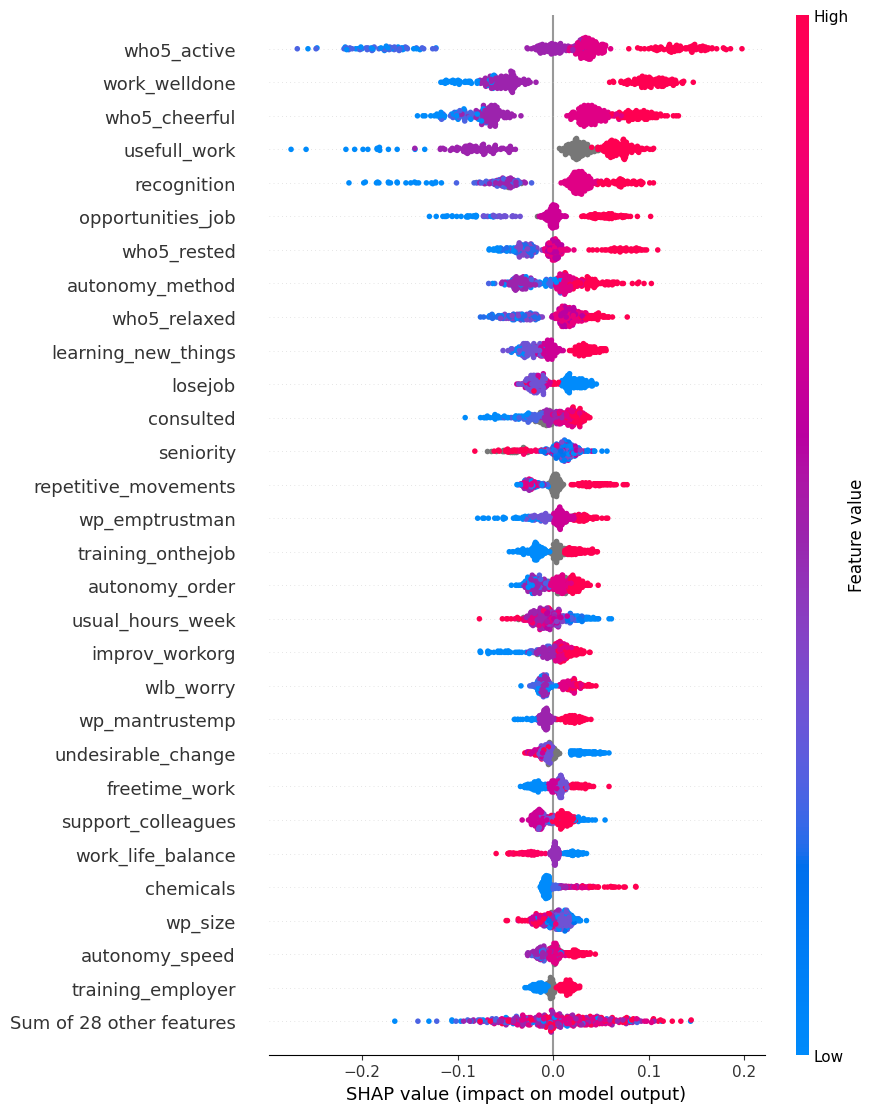

In [13]:
shap.plots.beeswarm(shap_values, max_display=30)